In [1]:
%reset -f
import os
import sys
import pathlib
# import argparse

sys.path.append('/home/psimmerl/mds_analysis')

import math
import numpy as np
import numba as nb
from math import ceil, floor

import pickle

# from src.helper_functions import alert, Table
# from src.histo_utilities import std_color_list as SCL

from src import CMS_lumi, tdrstyle
root_style = tdrstyle.setTDRStyle()

import ROOT as rt
from ROOT import RDataFrame
# from ROOT import TNtuple, TTree, TBranch, RDataFrame
from ROOT import TCanvas, TLatex, TLegend, TLine, TBox
from ROOT import TH1D, TH2D, TGraph, TGraphErrors, TGraphAsymmErrors

from src.helper_functions import alert, Table, weight_calc

# **************************** #
OUT_DIR = 'reports/weekly/2024-03-27'
LOCAL_OUT_DIR = '/home/psimmerl/mds_analysis'  # os.getcwd()

DATA_VERSION = '6'
LUMI = 23.02 * 1000
PI = rt.TMath.Pi()

LOCAL_DATA_DIR = '/home/psimmerl/mds_analysis/data'  # os.getcwd() + '/data/raw'
DATA_DIR = LOCAL_DATA_DIR#'TIER2' if 'caltech' in os.uname()[1] else 'LOCAL'
OUT_DIR = f'{LOCAL_OUT_DIR}/{OUT_DIR}'

pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

ROOT_ERROR_LEVEL = 1001  # rt.kInfo + 1
rt.gErrorIgnoreLevel = ROOT_ERROR_LEVEL

SCL = [1, 2, 4, 8, 6, 28, 43, 7, 25, 36, 30, 40, 42, 49, 46, 38, 32, 800, 600, 900, 870, 840]

gc = []

# **************** #

TAG_CATEGORY = ('csccsc', 'cscdt')[0]
SIZE_VAR = TAG_CATEGORY[3:]

if 'csccsc' in TAG_CATEGORY:
    LOW_MET, HIGH_MET = 75, 150
if 'cscdt' in TAG_CATEGORY:
    LOW_MET, HIGH_MET = 75, 150

FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}_scs_low_rdf.root'
FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}_scs_low_rdf.root'

# FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}OOT_l1_rdf.root'
# FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}OOT_l1_rdf.root'

FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}_l1_rdf.root'
FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}_l1_rdf.root'


# **************** #
print(f'{TAG_CATEGORY=}')
print(f'{SIZE_VAR=}')
print('')

print(f'{FN_MC=}')
print(f'{FN_R3=}')
print(f'{OUT_DIR=}')
print('')

rdfs = {
    'mc' : RDataFrame('MuonSystem_flat', FN_MC),
    'r3' : RDataFrame('MuonSystem_flat', FN_R3),
}

print('Events Read:')
for key, rdf in rdfs.items():
    # print('!!!!!!!!!!!!!!!!!!!!')
    # print('!! CUTTING ON MET !!')
    # print('!!!!!!!!!!!!!!!!!!!!')
    # rdf = rdf.Filter('met > 150')

    if SIZE_VAR == 'csc':
        rdf = rdf.Alias('tag_size', 'csc1Size')
        rdf = rdf.Alias('tag_ctau', 'csc1CTau')
    elif SIZE_VAR == 'dt':
        rdf = rdf.Alias('tag_size', 'dtSize')
        rdf = rdf.Alias('tag_ctau', 'dtCTau')

    count, weight = rdf.Count().GetValue(), rdf.Sum('weight').GetValue()
    print(f'  {key} = {count:,} ({weight:,.2f})')

    rdfs[key] = rdf

Welcome to JupyROOT 6.30/02
TAG_CATEGORY='csccsc'
SIZE_VAR='csc'

FN_MC='/home/psimmerl/mds_analysis/data/processed/mc_csccsc_l1_rdf.root'
FN_R3='/home/psimmerl/mds_analysis/data/processed/r3_csccsc_l1_rdf.root'
OUT_DIR='/home/psimmerl/mds_analysis/reports/weekly/2024-03-27'

Events Read:
  mc = 3,251 (1,963.90)
  r3 = 6,224 (6,224.00)


Signal (#DeltaR > 1.5) 1908.3200444594695 events
Data (#DeltaR > 1.5) 2092.0 events
Bump? (#DeltaR < 1.5) 4132.0 events


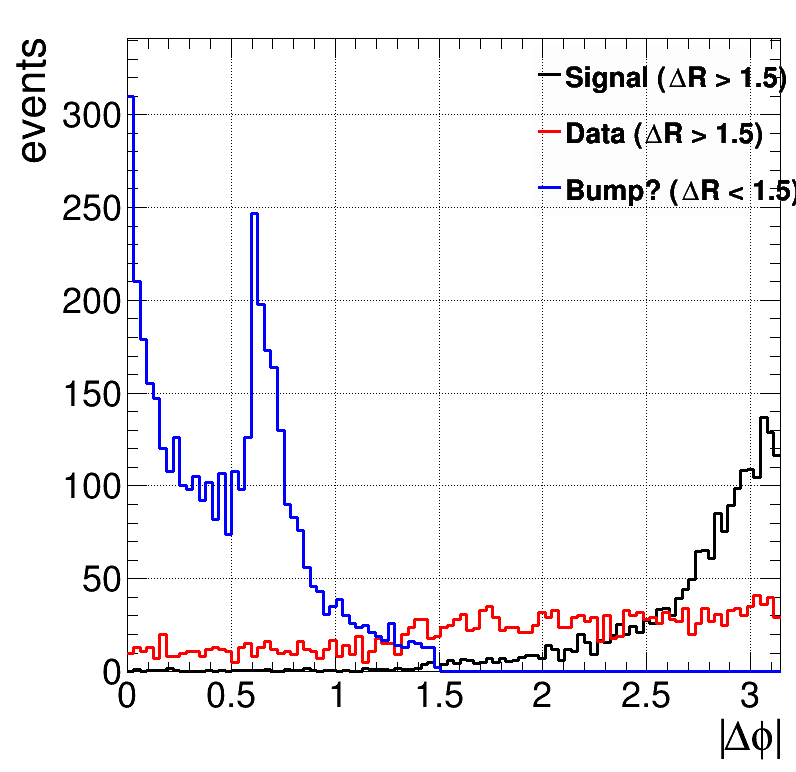

In [18]:
canvas = TCanvas('','',800,800)
canvas.SetGrid()
# canvas.SetLogy()

legend = TLegend(0.67, 0.72, 0.94, 0.94)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kBlack, 0.0)#0.2)
legend.SetTextSize(0.04)
legend.SetMargin(0.15)

wt = 'weight'

xv = 'tag_dPhi'
txy_label = f';|#Delta#phi|;events'
form =(txy_label,100,0,np.pi)

# **** #

# no cut
# Signal 1442.5667192685069 events
# Data 5317.0 events

dphi_cut = '1.0 < tag_dPhi'
# Signal 1430.4849209496751 events
# Data 1578.0 events
# bump_cut = '(0.55 < tag_dPhi) && (tag_dPhi < 0.8)'
bump_cut = 'tag_dR < 1'

better_bcut = '(csc1MaxStationRatio < 0.9)'
# Signal 738.8019671965594 events
# Data 602.0 events
better_bcut = '!((csc1NStation10  == 1) && (csc1AvgStation10 > 2.5))'
# Signal 1308.4587579294748 events
# Data 3951.0 events
# better_bcut = f'{dphi_cut} && (csc1MaxStationRatio < 0.9) && !((csc1NStation10  == 1) && (csc1AvgStation10 > 2.5))'
# Signal 735.1774277009099 events
# Data 547.0 events
# better_bcut = f'{dphi_cut} && !((csc1NStation10  == 1) && (csc1AvgStation10 > 2.5))'
better_bcut = '!((csc1AvgStation10  == 4) && (csc1MaxStationRatio > 0.7))'

better_bcut = 'tag_dEta > 0.5'
better_bcut = 'tag_dR > 1.5'#0.9'

# **** #

# h1 = rdfs['mc'].Filter(dphi_cut).Histo1D(('Signal',*form),xv,wt).GetValue()
# h2 = rdfs['r3'].Filter(dphi_cut).Histo1D(('Data',*form),xv,wt).GetValue()
# hhs = [h1,h2]

h1 = rdfs['mc'].Histo1D(('Signal',*form),xv,wt).GetValue()
h2 = rdfs['r3'].Histo1D(('Data',*form),xv,wt).GetValue()
# h2 = rdfs['r3'].Filter(f'{better_bcut}').Histo1D(('Data',*form),xv,wt).GetValue()
# h3 = rdfs['r3'].Filter(bump_cut).Histo1D(('Bump (Data)',*form),xv,wt).GetValue()
# h3 = rdfs['r3'].Filter(bump_cut).Histo1D(('Bump (Data)',*form),xv,wt).GetValue()
h3 = rdfs['r3'].Filter(f'!({better_bcut})').Histo1D(('Bump?',*form),xv,wt).GetValue()
hhs = [h1,h2,h3]


h1 = rdfs['mc'].Filter(better_bcut).Histo1D(('Signal (#DeltaR > 1.5)',*form),xv,wt).GetValue()
h2 = rdfs['r3'].Filter(better_bcut).Histo1D(('Data (#DeltaR > 1.5)',*form),xv,wt).GetValue()
h3 = rdfs['r3'].Filter(f'!({better_bcut})').Histo1D(('Bump? (#DeltaR < 1.5)',*form),xv,wt).GetValue()
hhs = [h1,h2, h3]


hmax = max([h.GetMaximum() for h in hhs])
# hmax = max([h.GetMaximum() / h.Integral() if h.Integral() else 0 for h in hhs])
for ih, hh in enumerate(hhs):
    nev = hh.Integral()
    print(hh.GetName(), nev, 'events')
    if hmax < 1 and nev:
        hh.Scale(1/hh.Integral())
        hh.GetYaxis().SetTitle('fraction of events')
    hh.SetMinimum(0)
    hh.SetMaximum(hmax*1.1)
    hh.SetLineColor(SCL[ih])
    hh.SetLineWidth(3)
    hh.Draw('hist same')
    legend.AddEntry(hh, hh.GetName(), 'L')

# l = TLine(1.0,0,1.0,hmax*1.1)
# l.SetLineColor(rt.kMagenta)
# l.SetLineWidth(3)
# l.Draw()

legend.Draw()

legend.Draw()
canvas.Draw()


In [19]:
# Dirty f-test to find potential variables
vars = {str(c):0 for c in rdfs['r3'].GetColumnNames()}
for v in vars:
    if v in ('weight','csc0CTau','csc1CTau','dtCTau', 'tag_ctau'):
        continue
    rd, rb = rdfs['r3'].Filter(dphi_cut), rdfs['r3'].Filter(bump_cut)
    dmin, dmax, bmin, bmax = rd.Min(v), rd.Max(v), rb.Min(v), rb.Max(v)
    dmin, dmax, bmin, bmax = dmin.GetValue(), dmax.GetValue(), bmin.GetValue(), bmax.GetValue()
    
    # xmin, xmax = min([vs_bump.min(), vs_data.min()]), max([vs_bump.max(), vs_data.max()])
    # xmin, xmax = max([dmin, bmin]), min([dmax, bmax])
    xmin, xmax = min([dmin, bmin]), max([dmax, bmax])
    rd = rdfs['mc']#.Filter(f'({dphi_cut}) && ({xmin} <= {v}) && ({v} <= {xmax})')
    # rd = rdfs['r3'].Filter(f'({dphi_cut}) && ({xmin} <= {v}) && ({v} <= {xmax})')
    rb = rdfs['r3'].Filter(f'({bump_cut}) && ({xmin} <= {v}) && ({v} <= {xmax})')
    vs_data = rd.AsNumpy([v])[v].astype(float)
    vs_bump = rb.AsNumpy([v])[v].astype(float)
    ndata, nbump = len(vs_data), len(vs_bump)

    nb_data = int((xmax-xmin)/(2.718*vs_data.std()*ndata**(-1/3))) if vs_data.std()>0 else 5
    nb_bump = int((xmax-xmin)/(2.718*vs_bump.std()*nbump**(-1/3))) if vs_bump.std()>0 else 5
    nb = min(nb_data, nb_bump)
    print(v, nb, xmin, xmax)

    hdata = np.histogram(vs_data, nb, (xmin, xmax), density=True)
    hbump = np.histogram(vs_bump, nb, (xmin, xmax), density=True)

    rms = np.sum((hdata[0]-hbump[0])**2)**0.5
    vars[v] = rms
    print(v, rms)



csc0AvgStation10 14 -4.0 4.0
csc0AvgStation10 0.5547492705586562
csc0Eta 15 -2.3344550132751465 2.3046913146972656
csc0Eta 0.2855937231925562
csc0JetVetoE 239 0.0 2383.846435546875
csc0JetVetoE 0.020071938913678974
csc0JetVetoLooseId 16 0.0 1.0
csc0JetVetoLooseId 0.9624968121387841
csc0JetVetoPt 195 0.0 763.9097900390625
csc0JetVetoPt 0.05159660339756732
csc0JetVetoTightId 20 0.0 1.0
csc0JetVetoTightId 0.3374336568333738
csc0MaxChamber 11 770.0 1989996768.0
csc0MaxChamber 1.1617583354011595e-09
csc0MaxChamberRatio 14 0.13818036019802094 5359569.0
csc0MaxChamberRatio 4.954783009225787e-07
csc0MaxStation 14 -4.0 4.0
csc0MaxStation 0.5759064673817508
csc0MaxStationRatio 28 0.3855173885822296 1.0
csc0MaxStationRatio 16.93902862064729
csc0Met_dPhi 19 -3.1414852142333984 3.141359567642212
csc0Met_dPhi 0.14808810920860718
csc0MuonVetoE 26 0.0 9207.978515625
csc0MuonVetoE 8.514404325185042e-06
csc0MuonVetoGlobal 31 0.0 1.0
csc0MuonVetoGlobal 0.47414864531651624
csc0MuonVetoLooseId 20 0.0 1.0
c

In [20]:
print(r'\begin{center}')
print(r'\begin{tabular}{c|c}')
print(r'    \hline')
print(f'    Variable & Histo RMS \\\\')
print(r'    \hline')
for k, v in sorted([(k,v) for k, v in vars.items()], key=lambda x: -x[1])[:10]:
    print(f'    {k.replace("_"," ")} & {v:.2f} \\\\')
print(r'\end{tabular}')
print(r'\end{center}')

\begin{center}
\begin{tabular}{c|c}
    \hline
    Variable & Histo RMS \\
    \hline
    csc0MaxStationRatio & 16.94 \\
    csc1MaxStationRatio & 15.55 \\
    tag dR & 6.40 \\
    tag dPhi & 5.03 \\
    csc1NStation10 & 4.43 \\
    csc0NStation10 & 3.26 \\
    tag dEta & 2.01 \\
    csc0JetVetoLooseId & 0.96 \\
    csc1MuonVetoGlobal & 0.96 \\
    csc0MuonVetoLooseId & 0.71 \\
\end{tabular}
\end{center}


In [21]:
cols_keep = [
    'csc0AvgStation10',
    'csc0Eta',
    'csc0JetVetoE',
    'csc0JetVetoLooseId',
    'csc0JetVetoPt',
    'csc0JetVetoTightId',
    'csc0MaxChamber',
    'csc0MaxChamberRatio',
    'csc0MaxStation',
    'csc0MaxStationRatio',
    'csc0Met_dPhi',
    'csc0MuonVetoE',
    'csc0MuonVetoGlobal',
    'csc0MuonVetoLooseId',
    'csc0MuonVetoPt',
    'csc0NChamber',
    'csc0NRechitChamberMinus11',
    'csc0NRechitChamberMinus12',
    'csc0NRechitChamberMinus13',
    'csc0NRechitChamberMinus21',
    'csc0NRechitChamberMinus22',
    'csc0NRechitChamberMinus31',
    'csc0NRechitChamberMinus32',
    'csc0NRechitChamberMinus41',
    'csc0NRechitChamberMinus42',
    'csc0NRechitChamberPlus11',
    'csc0NRechitChamberPlus12',
    'csc0NRechitChamberPlus13',
    'csc0NRechitChamberPlus21',
    'csc0NRechitChamberPlus22',
    'csc0NRechitChamberPlus31',
    'csc0NRechitChamberPlus32',
    'csc0NRechitChamberPlus41',
    'csc0NRechitChamberPlus42',
    'csc0NStation10',
    'csc0Phi',
    'csc0R',
    'csc0Size',
    'csc0Time',
    'csc0TimeSpread',
    'csc0TimeSpreadWeightedAll',
    'csc0TimeWeighted',
    'csc0X',
    'csc0Y',
    'csc0Z',
    'csc0_match_MB1Seg_0p4',
    'csc0_match_RB1_0p4',
    'csc0_match_RE12_0p4',
    'csc0_match_dtSeg_0p4',
    'csc1AvgStation10',
    'csc1Eta',
    'csc1JetVetoE',
    'csc1JetVetoLooseId',
    'csc1JetVetoPt',
    'csc1JetVetoTightId',
    'csc1MaxChamber',
    'csc1MaxChamberRatio',
    'csc1MaxStation',
    'csc1MaxStationRatio',
    'csc1Met_dPhi',
    'csc1MuonVetoE',
    'csc1MuonVetoGlobal',
    'csc1MuonVetoLooseId',
    'csc1MuonVetoPt',
    'csc1NChamber',
    'csc1NRechitChamberMinus11',
    'csc1NRechitChamberMinus12',
    'csc1NRechitChamberMinus13',
    'csc1NRechitChamberMinus21',
    'csc1NRechitChamberMinus22',
    'csc1NRechitChamberMinus31',
    'csc1NRechitChamberMinus32',
    'csc1NRechitChamberMinus41',
    'csc1NRechitChamberMinus42',
    'csc1NRechitChamberPlus11',
    'csc1NRechitChamberPlus12',
    'csc1NRechitChamberPlus13',
    'csc1NRechitChamberPlus21',
    'csc1NRechitChamberPlus22',
    'csc1NRechitChamberPlus31',
    'csc1NRechitChamberPlus32',
    'csc1NRechitChamberPlus41',
    'csc1NRechitChamberPlus42',
    'csc1NStation10',
    'csc1Phi',
    'csc1R',
    'csc1Size',
    'csc1Time',
    'csc1TimeSpread',
    'csc1TimeSpreadWeightedAll',
    'csc1TimeWeighted',
    'csc1X',
    'csc1Y',
    'csc1Z',
    'csc1_match_MB1Seg_0p4',
    'csc1_match_RB1_0p4',
    'csc1_match_RE12_0p4',
    'csc1_match_dtSeg_0p4',
    'met',
    'metPhi',
    'nJets',
    'nLeptons',
    'tag_dEta',
]

cols_discard = [
    'weight',
    'evtNum',
    'csc0CTau',
    'csc1CTau',
    'tag_ctau',
    'tag_size',
    'tag_dPhi',
    'tag_dR',

    # 'tag_dEta',
]

In [22]:
from sklearn.ensemble import RandomForestClassifier

bump_dict = rdfs['r3'].Filter(f'({bump_cut})').AsNumpy()
else_dict = rdfs['r3'].Filter(f'!({bump_cut})').AsNumpy()
cols = list(bump_dict.keys())

for c in cols_discard:
    cols.remove(c)

X_bump = np.array([bump_dict[c] for c in cols], dtype=float).T
X_else = np.array([else_dict[c] for c in cols], dtype=float).T

X = np.r_[X_bump, X_else]
y = np.r_[np.ones(len(X_bump)), np.zeros(len(X_else))]

cols.append('NOISE')
X = np.c_[X, np.random.randn(len(X))]

X_aves = np.mean(X, 0)
X_stds = np.std(X, 0)
X_stds[X_stds == 0] = 1

X = (X - X_aves) / X_stds


In [23]:

rfc = RandomForestClassifier(n_estimators=1000, min_samples_split=10, max_depth=5)
rfc.fit(X, y)

scores = rfc.feature_importances_
idxs = np.argsort(scores)[::-1]

for i in idxs:
    print(cols[i], scores[i])

tag_dEta 0.30496039313152795
csc0Time 0.07541523553329488
csc0TimeWeighted 0.0469116829550776
csc1MaxChamberRatio 0.04154515112439333
csc0Size 0.033164415012024155
csc0JetVetoPt 0.03281448590066153
csc0MaxChamberRatio 0.031347109059769986
csc1Size 0.024177185867992602
csc1R 0.022701598013751077
csc1MaxChamber 0.022568985761465776
csc0JetVetoE 0.020932352152390456
csc0MaxChamber 0.020646899984950638
csc0JetVetoTightId 0.018503984551511164
csc1Eta 0.01751495627808394
csc0JetVetoLooseId 0.016492490382408433
csc1Z 0.015372324679232963
csc1AvgStation10 0.014708557044891346
csc0Z 0.014690151196078817
csc0R 0.014457364142978178
csc1MaxStationRatio 0.013568266787473358
csc1MaxStation 0.013526861864638036
csc0AvgStation10 0.01350624824250571
csc0Eta 0.012810797611003753
csc0MaxStation 0.012081115134679755
csc0TimeSpread 0.008880726471569542
csc0NRechitChamberMinus22 0.007575945693313157
csc0_match_RE12_0p4 0.007268206902113818
csc0MaxStationRatio 0.006492010816659667
nJets 0.006013736371833348


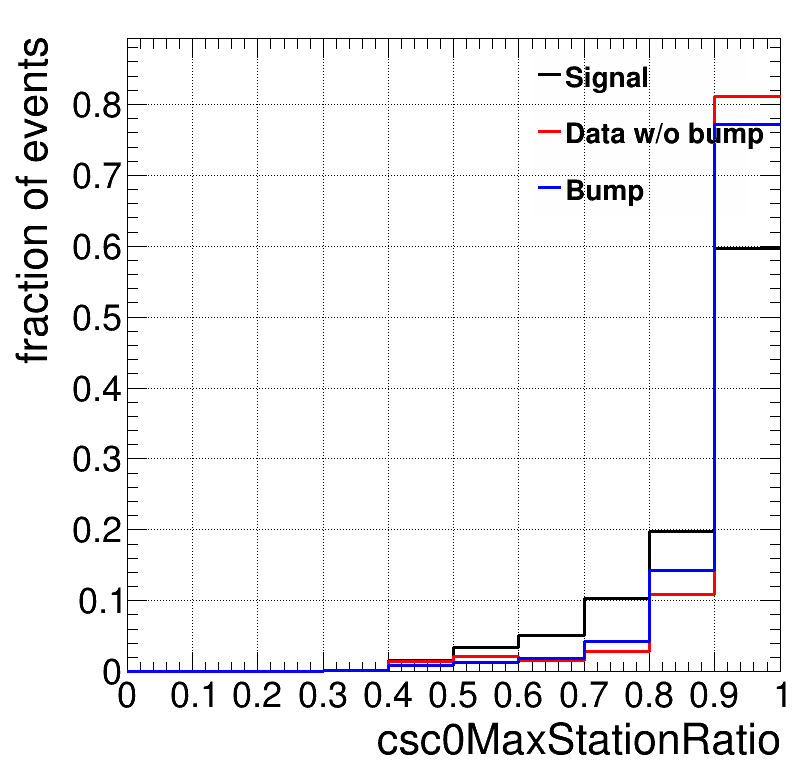

In [27]:
canvas = TCanvas('','',800,800)
canvas.SetGrid()
# canvas.SetLogy()

legend = TLegend(0.67, 0.72, 0.94, 0.94)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kBlack, 0.0)#0.2)
legend.SetTextSize(0.04)
legend.SetMargin(0.15)

xv = 'csc0MaxChamber'
txy_label = f';csc0MaxChamber;fraction of events'
form =(txy_label,32,0,10000)

xv = 'csc0MaxStationRatio'
txy_label = f';csc0MaxStationRatio;fraction of events'
form =(txy_label,10,0,1)

# xv = 'csc1MaxStationRatio'
# txy_label = f';csc1MaxStationRatio;fraction of events'
# form =(txy_label,20,0,1)

# xv = 'csc1NStation10'
# txy_label = f';csc1NStation10;fraction of events'
# form =(txy_label,20,0,10)

# xv = 'csc1R'
# txy_label = f';2nd csc R;fraction of events'
# form =(txy_label,20,100,600)

# # xv = 'csc1TimeSpreadWeightedAll'
# # txy_label = f';csc1TimeSpreadWeightedAll;fraction of events'
# # form =(txy_label,50,0,20)

# # xv = 'csc0JetVetoLooseId'
# # txy_label = f';csc0JetVetoLooseID;fraction of events'
# # form =(txy_label,50,0,20)

# xv = 'csc0MaxChamberRatio'
# txy_label = f';csc0MaxChamberRatio;fraction of events'
# form =(txy_label,100,0,1)

# # xv = 'tag_dEta'
# # txy_label = f';#Delta#eta;fraction of events'
# # form =(txy_label,100,0,5)

# xv = 'tag_dR'
# txy_label = f';#DeltaR;fraction of events'
# form =(txy_label,100,0,5)



# **** #

# h1 = rdfs['mc'].Filter(dphi_cut).Histo1D(('Signal',*form),xv,).GetValue()
# h2 = rdfs['r3'].Filter(dphi_cut).Histo1D(('Data',*form),xv,).GetValue()
# h3 = rdfs['r3'].Filter(bump_cut).Histo1D(('Bump',*form),xv,).GetValue()

h1 = rdfs['mc'].Histo1D(('Signal',*form),xv,).GetValue()
h2 = rdfs['r3'].Filter(f'!({bump_cut})').Histo1D(('Data w/o bump',*form),xv,).GetValue()
h3 = rdfs['r3'].Filter(bump_cut).Histo1D(('Bump',*form),xv,).GetValue()


hhs = [h1,h2,h3]
# hmax = max([h.GetMaximum() for h in hhs])
hmax = max([h.GetMaximum() / h.Integral() if h.Integral() else 0 for h in hhs])
for ih, hh in enumerate(hhs):
    nev = hh.Integral()
    if hmax < 1 and nev:
        hh.Scale(1/hh.Integral())
    hh.SetMinimum(0)
    hh.SetMaximum(hmax*1.1)
    hh.SetLineColor(SCL[ih])
    hh.SetLineWidth(3)
    hh.Draw('hist same')
    legend.AddEntry(hh, hh.GetName(), 'L')

# l = TLine(1.0,0,1.0,hmax*1.1)
# l.SetLineColor(rt.kMagenta)
# l.SetLineWidth(3)
# l.Draw()

legend.Draw()
canvas.Draw()


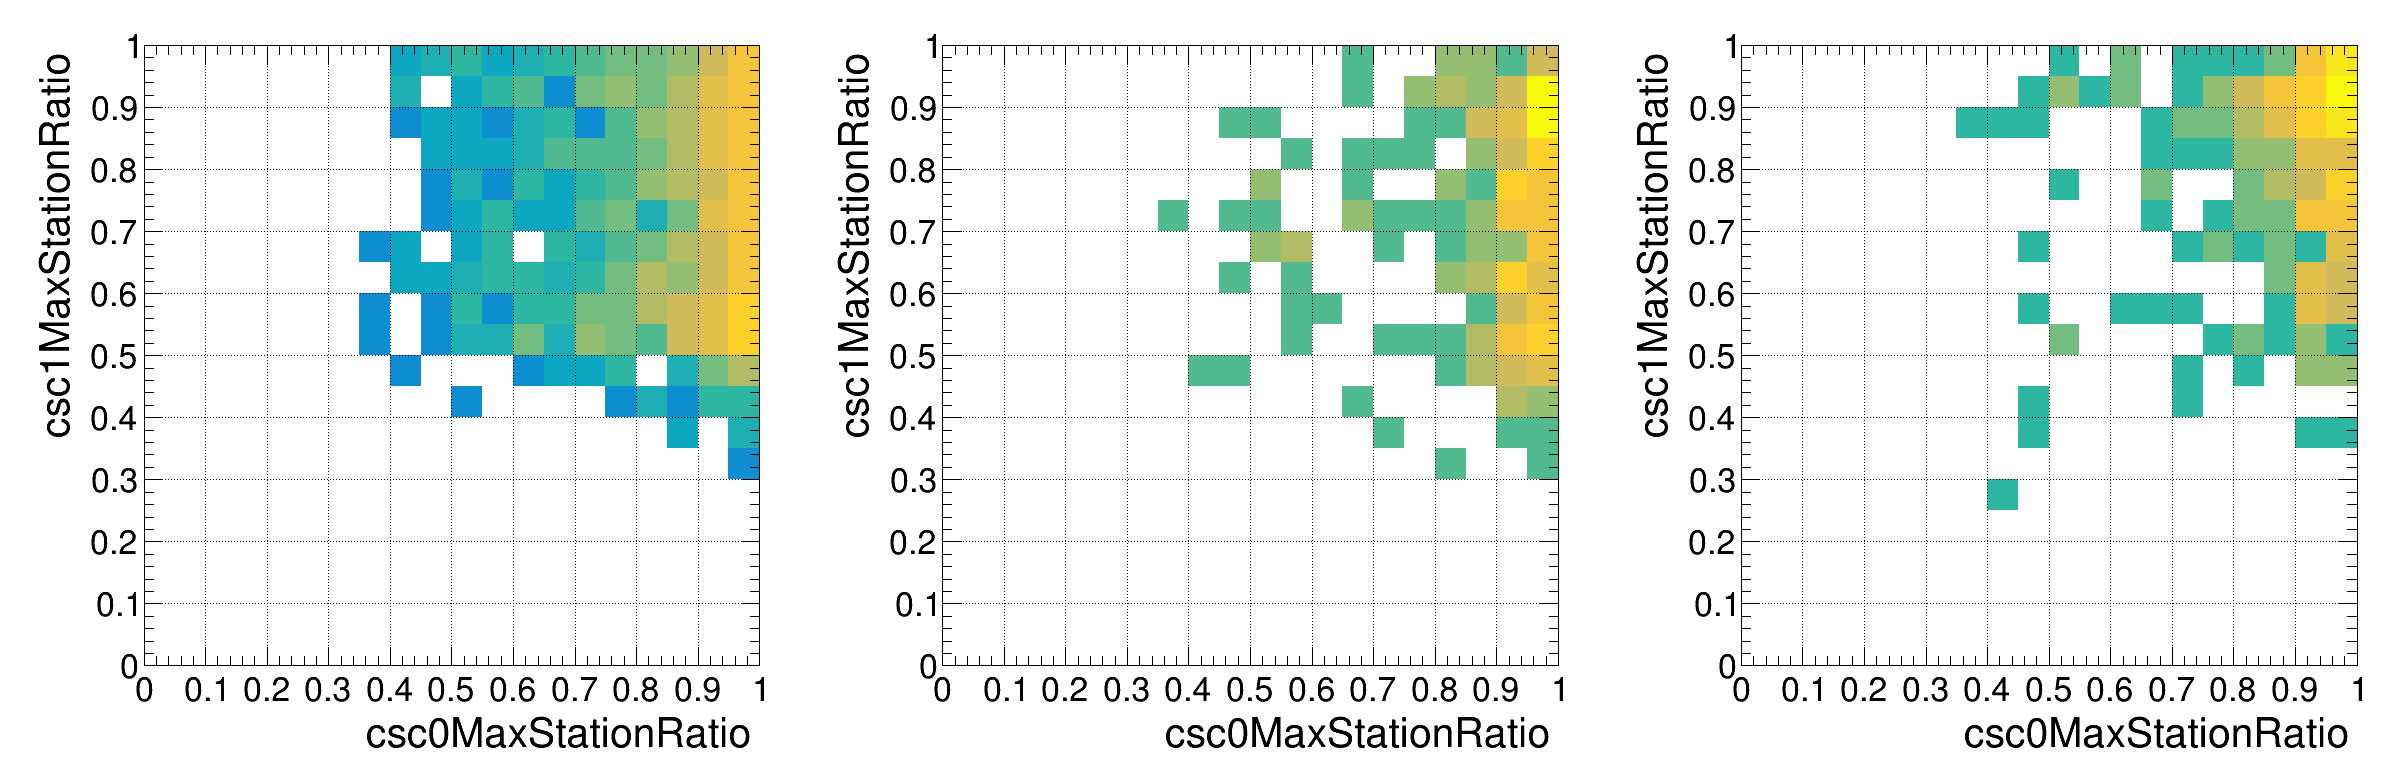

In [28]:
canvas = TCanvas('','',3*800,800)
canvas.Divide(3,1)


# **** #

nb = 20
xv, yv = 'csc0Phi', 'csc1Phi'
txy_label = f';1st csc phi;2nd csc phi;fraction of events'
bins = (nb, 0, np.pi, nb, 0, np.pi)
logxyz = (False, False, True)

nb = 20
xv, yv = 'csc0Phi', 'tag_dEta'
txy_label = f';1st csc phi;#Delta#eta;fraction of events'
bins = (nb, 0, np.pi, nb, 0, 5)
logxyz = (False, False, True)

nb = 20
xv, yv = 'csc1Phi', 'tag_dEta'
txy_label = f';2nd csc phi;#Delta#eta;fraction of events'
bins = (nb, 0, np.pi, nb, 0, 5)
logxyz = (False, False, True)

nb = 20
xv, yv = 'csc0Phi', 'csc0R'
txy_label = f';1st csc phi;1st csc R;fraction of events'
bins = (nb, 0, np.pi, nb, 100, 700)
logxyz = (False, False, True)

nb = 20
xv, yv = 'csc1Phi', 'csc1R'
txy_label = f';2nd csc phi;2nd csc R;fraction of events'
bins = (nb, 0, np.pi, nb, 100, 700)
logxyz = (False, False, True)

nb = 50
xv, yv = 'csc1R', 'tag_dEta'
txy_label = f';2nd csc R;#Delta#eta;fraction of events'
bins = (nb, 100, 700, nb, 0, 1.5)
logxyz = (False, False, True)

# nb = 20
# xv, yv = 'csc0R', 'csc1R'
# txy_label = f';1st csc R;2nd csc R;fraction of events'
# bins = (nb, 100, 700, nb, 100, 700)
# logxyz = (False, False, True)


nb = 20
xv, yv = 'csc0MaxStationRatio', 'csc1MaxStationRatio'
txy_label = f';csc0MaxStationRatio;csc1MaxStationRatio;fraction of events'
bins = (nb, 0, 1, nb, 0, 1)
logxyz = (False, False, True)

# nb = 20
# xv, yv = 'tag_dEta', 'csc1MaxStationRatio'
# txy_label = f';tag_dEta;csc1MaxStationRatio;fraction of events'
# bins = (nb, 0, 5, nb, 0, 1)
# bins = (nb, 0, 1.5, nb, 0, 1)
# logxyz = (False, False, True)

# nb = 20
# xv, yv = 'csc0Eta', 'tag_dEta'
# txy_label = f';csc0Eta;tag_dEta;fraction of events'
# bins = (nb, 0, 5, nb, 0, 1)
# bins = (nb, 0, 1.5, nb, 0, 1.5)
# logxyz = (False, False, True)


# nb = 20
# xv, yv = 'tag_dR', 'tag_dEta'
# txy_label = f';tag_dR;tag_dEta;fraction of events'
# bins = (nb, 0, 5, nb, 0, 1)
# bins = (nb, 0, 1.5, nb, 0, 1.5)
# logxyz = (False, False, True)

# nb = 10
# xv, yv = 'tag_dEta', 'tag_size'
# txy_label = f';tag_dEta;tag_size;fraction of events'
# bins = (nb, 0, 1.5, nb, 50, 100)
# logxyz = (False, False, True)


# nb = 10
# xv, yv = 'csc1NStation10', 'csc1MaxStationRatio'
# txy_label = f';csc1NStation10;csc1MaxStationRatio;fraction of events'
# bins = (6, -0.5, 5.5, nb, 0, 1)
# logxyz = (False, False, False)

# nb = 10
# xv, yv = 'csc1AvgStation10', 'csc1MaxStationRatio'
# txy_label = f';csc1AvgStation10;csc1MaxStationRatio;fraction of events'
# bins = (6, -0.5, 5.5, nb, 0, 1)
# logxyz = (False, False, True)


# nb = 10
# xv, yv = 'csc1AvgStation10', 'csc1MaxStation'
# txy_label = f';csc1AvgStation10;csc1MaxStation;fraction of events'
# bins = (6, -0.5, 5.5, 6, -0.5, 5.5)
# logxyz = (False, False, False)

# nb = 10
# xv, yv = 'csc1NStation10', 'csc1AvgStation10'
# txy_label = f';csc1NStation10;csc1AvgStation10;fraction of events'
# bins = (6, -0.5, 5.5, 6, -0.5, 5.5)
# logxyz = (False, False, False)



# **** #

h1 = rdfs['mc'].Histo2D(('Signal',txy_label,*bins),xv,yv).GetValue()
h2 = rdfs['r3'].Filter(f'!({bump_cut})').Histo2D(('Data',txy_label,*bins),xv,yv).GetValue()
h3 = rdfs['r3'].Filter(bump_cut).Histo2D(('Bump',txy_label,*bins),xv,yv).GetValue()

hhs = [h1,h2,h3]
hmax = max([h.GetMaximum() / h.Integral() for h in hhs])
for ih, hh in enumerate(hhs):
    canvas.cd(ih + 1).SetGrid()
    if logxyz[0]:
        canvas.cd(ih + 1).SetLogx()
    if logxyz[1]:
        canvas.cd(ih + 1).SetLogy()
    if logxyz[2]:
        canvas.cd(ih + 1).SetLogz()
    
    hh.Scale(1/hh.Integral())
    hh.SetMinimum(0)
    hh.SetMaximum(hmax*1.1)
    hh.SetLineColor(SCL[ih])
    hh.SetLineWidth(3)
    # if ih:
    #     hh.Divide(h1)
    # hh.Draw('col text')
    hh.Draw('col')



# legend.Draw()
canvas.Draw()
